# Kraken Analyzer - Overview Dashboard

This notebook provides a high-level overview of the Kraken placement engine experiment results.

**Data Source**: `../data/curated/experiments.parquet`  
**Safety**: All metrics check for column existence before computing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.ticker as ticker


# Configure plotting
plt.style.use("default")
sns.set_palette("husl")
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)

print("Kraken Analyzer - Overview Dashboard")
print(f"Pandas: {pd.__version__}")

Kraken Analyzer - Overview Dashboard
Pandas: 2.2.3


## Load Curated Dataset

This section loads the curated dataset from a Parquet file. The data has already been cleanded, validated and structured during the ingestion phase, making it ready for analysis.

In [4]:
# Load curated parquet file
data_path = Path("../data/curated/experiments.parquet")

if not data_path.exists():
    print(f"Curated dataset not found: {data_path}")
    print("   Run 'make analyze' from the root directory first.")
    raise FileNotFoundError("Please run data ingestion first")

df = pd.read_parquet(data_path)
print(f"Loaded dataset: {len(df):,} rows × {len(df.columns)} columns")
print(
    f"Data range: {df['synced_at'].min() if 'synced_at' in df.columns else 'Unknown'} to {df['synced_at'].max() if 'synced_at' in df.columns else 'Unknown'}"
)

Loaded dataset: 1,200 rows × 29 columns
Data range: 2025:09:09T05:34:04Z to 2025:09:09T05:34:04Z


## Dataset Overview

This section provides a quick summary of the experimental dataset, helping to understand its structure, content and the scope before diving into detailed analysis. 

### What you are seeing here: 
- Total number of runs (rows) and metrics (columns)
- Breakdown of experiments and schema versions if available
- Data types of each column
- Sample rows to get a feel for the data

In [6]:
print("=== Dataset Summary ===")
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")

# Show experiments if available
if "experiment_label" in df.columns:
    exp_counts = df["experiment_label"].value_counts()
    print(f"\nExperiments ({len(exp_counts)}):")
    for exp, count in exp_counts.items():
        print(f"  • {exp}: {count:,} rows")

# Show schema versions if available
if "schema_version" in df.columns:
    schema_counts = df["schema_version"].value_counts()
    print("\nSchema versions:")
    for version, count in schema_counts.items():
        print(f"  • {version}: {count:,} rows")

print("\n=== Column Overview ===")
print(df.dtypes)

=== Dataset Summary ===
Total rows: 1,200
Total columns: 29

Experiments (1):
  • kraken1.0_vs_INES: 1,200 rows

Schema versions:
  • v1: 1,200 rows

=== Column Overview ===
ines_simulation_id                    float64
kraken_simulation_id                  float64
network_size                            int64
event_skew                            float64
node_event_ratio                      float64
num_event_types                         int64
max_parents                             int64
workload_size                           int64
query_length                            int64
simulation_mode                        object
median_selectivity                    float64
total_projections_placed                int64
placement_difference_to_ines_count      int64
combigen_time_seconds                 float64
ines_placement_time_seconds           float64
ines_push_pull_time_seconds           float64
ines_total_time_seconds               float64
kraken_execution_time_seconds         float6

In [7]:
# Show first few rows
print("=== Sample Data ===")
display(df.head(5))

=== Sample Data ===


,ines_simulation_id,kraken_simulation_id,network_size,event_skew,node_event_ratio,num_event_types,max_parents,workload_size,query_length,simulation_mode,...,inev_cost,ines_cost,kraken_cost,all_push_central_latency,ines_latency,kraken_latency,experiment_label,schema_version,source,synced_at
0,NaN,NaN,10,2.0,0.5,6,5,5,3,random,...,8.144062e+04,4.935009e+04,8439.407690,3,1,16.0,kraken1.0_vs_INES,v1,cloud-11,2025:09:09T05:34:04Z
1,NaN,NaN,10,2.0,0.5,6,5,5,3,random,...,3.942382e+06,3.902411e+06,20667.005530,3,1,16.0,kraken1.0_vs_INES,v1,cloud-11,2025:09:09T05:34:04Z
2,NaN,NaN,10,2.0,0.5,6,5,5,3,random,...,3.411967e+05,2.992452e+05,23850.761721,3,1,11.0,kraken1.0_vs_INES,v1,cloud-11,2025:09:09T05:34:04Z
3,NaN,NaN,10,2.0,0.5,6,5,5,3,random,...,5.075987e+05,4.631782e+05,9871.551568,3,1,15.0,kraken1.0_vs_INES,v1,cloud-11,2025:09:09T05:34:04Z
4,NaN,NaN,10,2.0,0.5,6,5,5,3,random,...,9.741387e+05,9.325497e+05,15461.717421,3,1,15.0,kraken1.0_vs_INES,v1,cloud-11,2025:09:09T05:34:04Z


## Transmission Efficiency Analysis 

This section calculates and compares transmission efficiency between all-push-central-baseline, INEv, INES and Kraken frameworks. The trensmission ratio indicates how efficiently each framework handles data transmission compared to a naive "broadcast everything" baseline approach (all-push-central-baseline).

### How to interpret the transmission ratio:
- **Ratio = Framework Cost / All-Push-Central Cost**
- **Ratio < 1.0** indicates that the framework is more efficient than the broadcasting everything
- **Ratio > 1.0** indicates that the framework is less efficient than broadcasting everything
- In general, **lower ratios are better**, indicating more efficient data transmission 

In [9]:
# Let's calculate the transmission ratio for INEv, INES and Kraken by deviding by all_push_central_cost
def safe_divide(numerator, denominator):
    return numerator / denominator if denominator != 0 else np.nan

In [10]:
# Transmission Ratio for INEv
if all(col in df.columns for col in ["inev_cost", "all_push_central_cost"]):
    df["inev_transmission_ratio"] = df.apply(
        lambda row: safe_divide(row["inev_cost"], row["all_push_central_cost"]), axis=1
    )
    print(
        f"Mean INEv Transmission Ratio: {df['inev_transmission_ratio'].mean():.4f} ± {df['inev_transmission_ratio'].std():.4f}"
    )
    print(
        f"Mean INEv Transmission Ratio: {df['inev_transmission_ratio'].mean():.4f} ± {df['inev_transmission_ratio'].std():.4f}"
    )
else:
    print("Columns for INEv Transmission Ratio not found.")

Mean INEv Transmission Ratio: 34774.9405 ± 1102398.3549
Mean INEv Transmission Ratio: 34774.9405 ± 1102398.3549


In [11]:
# Transmission Ratio for INES
if all(col in df.columns for col in ["ines_cost", "all_push_central_cost"]):
    df["ines_transmission_ratio"] = df.apply(
        lambda row: safe_divide(row["ines_cost"], row["all_push_central_cost"]), axis=1
    )
    print(
        f"INES Transmission Ratio: {df['ines_transmission_ratio'].mean():.4f} ± {df['ines_transmission_ratio'].std():.4f}"
    )
else:
    print("Columns for INES Transmission Ratio not found.")

INES Transmission Ratio: 34774.2346 ± 1102398.3623


In [12]:
# Transmission Ratio for Kraken
if all(col in df.columns for col in ["kraken_cost", "all_push_central_cost"]):
    df["kraken_transmission_ratio"] = df.apply(
        lambda row: safe_divide(row["kraken_cost"], row["all_push_central_cost"]),
        axis=1,
    )
    print(
        f"Kraken Transmission Ratio: {df['kraken_transmission_ratio'].mean():.4f} ± {df['kraken_transmission_ratio'].std():.4f}"
    )
else:
    print("Columns for Kraken Transmission Ratio not found.")

Kraken Transmission Ratio: 0.0501 ± 0.0514


In [13]:
# Let's group every data by network size and query length and see how the transmission ratio changes, also add the number of runs for each group
group_cols = []
if "network_size" in df.columns:
    group_cols.append("network_size")
if "query_length" in df.columns:
    group_cols.append("query_length")
if group_cols:
    summary = (
        df.groupby(group_cols)
        .agg(
            inev_transmission_ratio_median=("inev_transmission_ratio", "median"),
            inev_transmission_ratio_mean=("inev_transmission_ratio", "mean"),
            ines_transmission_ratio_median=("ines_transmission_ratio", "median"),
            ines_transmission_ratio_mean=("ines_transmission_ratio", "mean"),
            kraken_transmission_ratio_median=("kraken_transmission_ratio", "median"),
            kraken_transmission_ratio_mean=("kraken_transmission_ratio", "mean"),
            runs=("inev_transmission_ratio", "count"),
        )
        .reset_index()
    )
    print("=== Transmission Ratio Summary by Group ===")
    display(summary)

=== Transmission Ratio Summary by Group ===


,network_size,query_length,inev_transmission_ratio_median,inev_transmission_ratio_mean,ines_transmission_ratio_median,ines_transmission_ratio_mean,kraken_transmission_ratio_median,kraken_transmission_ratio_mean,runs
0,10,3,1.123884,60.181243,0.692298,59.702512,0.108878,0.129954,50
1,10,5,0.673790,70.240154,0.163110,69.745077,0.092882,0.112932,50
2,10,8,0.670850,0.898791,0.127011,0.366299,0.086592,0.093894,50
3,10,10,0.669819,0.671492,0.108644,0.130936,0.103964,0.112733,50
4,30,3,0.879538,5448.843818,0.174762,5448.368307,0.091093,0.098820,50
5,30,5,0.754850,777268.267753,0.167655,777267.745677,0.079689,0.095952,50
6,30,8,0.506530,1.207471,0.117828,0.733862,0.050396,0.059971,50
7,30,10,0.502628,0.595401,0.098402,0.109250,0.069423,0.078280,50
8,50,3,1.000000,14.999951,0.181098,14.433769,0.060302,0.063198,50
9,50,5,0.789926,5007.143674,0.108045,5006.565953,0.040032,0.050444,50


## Visualizations

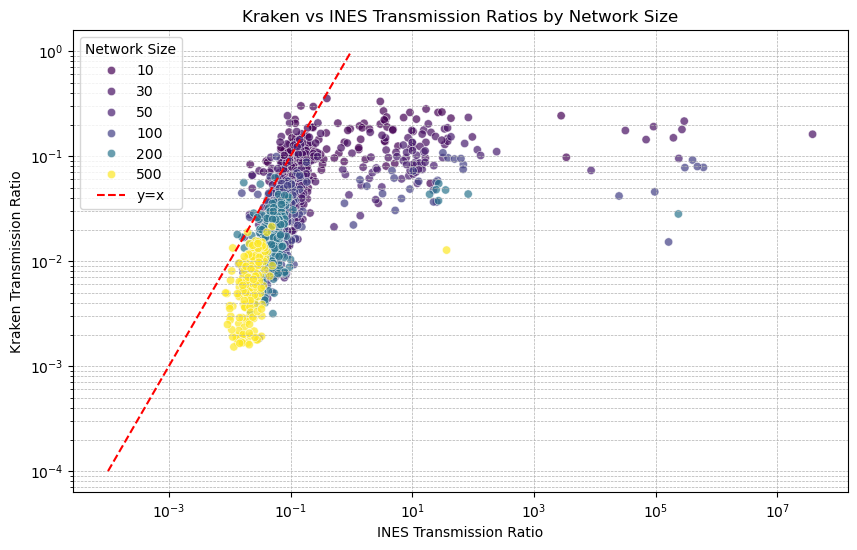

In [15]:
# Let's plot the transmission ratios between INES and Kraken, by network size
if all(
    col in df.columns
    for col in ["ines_transmission_ratio", "kraken_transmission_ratio", "network_size"]
):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="ines_transmission_ratio",
        y="kraken_transmission_ratio",
        hue="network_size",
        palette="viridis",
        alpha=0.7,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.plot([1e-4, 1], [1e-4, 1], "r--", label="y=x")
    plt.xlabel("INES Transmission Ratio")
    plt.ylabel("Kraken Transmission Ratio")
    plt.title("Kraken vs INES Transmission Ratios by Network Size")
    plt.legend(title="Network Size")
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()
else:
    print("Columns for Kraken vs INES Transmission Ratio plot not found.")

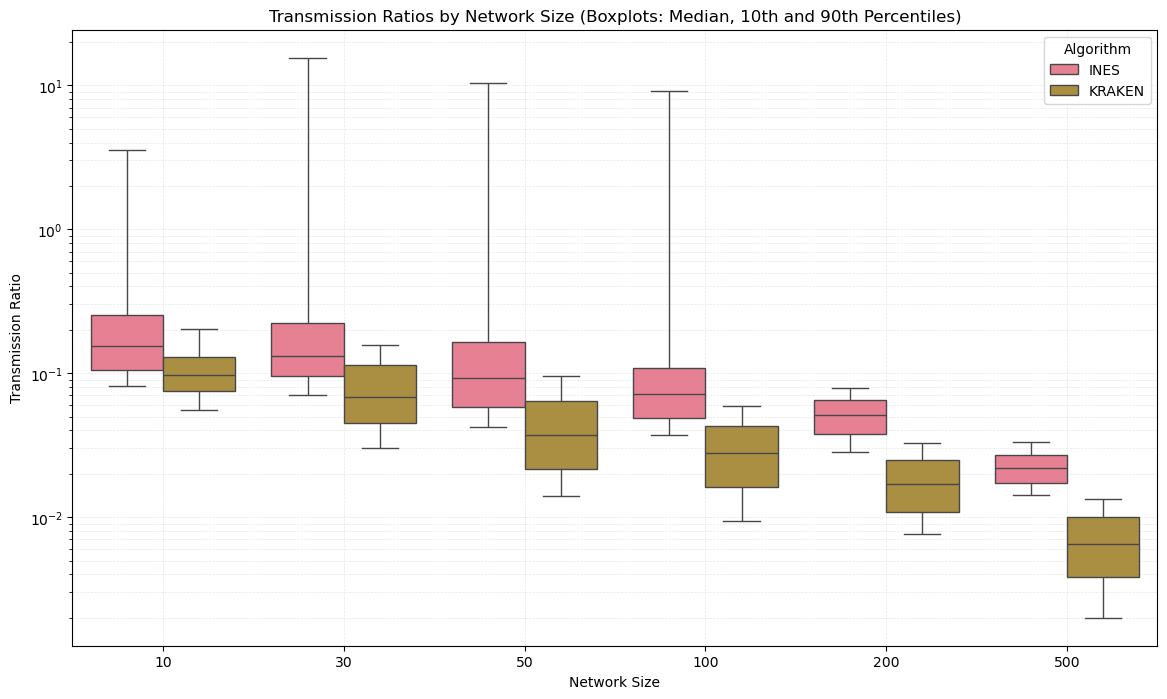

In [16]:
# Let´s plot the transmission ratios grouped by network size as a simple line chart with error bars.
if all(
    col in df.columns
    for col in [
        "network_size",
        "inev_transmission_ratio",
        "ines_transmission_ratio",
        "kraken_transmission_ratio",
    ]
):
    # Daten in long format umwandeln für seaborn
    df_long = df.melt(
        id_vars=["network_size"],
        value_vars=["ines_transmission_ratio", "kraken_transmission_ratio"],
        # value_vars=['inev_transmission_ratio', 'ines_transmission_ratio', 'kraken_transmission_ratio'],
        var_name="algorithm",
        value_name="transmission_ratio",
    )

    # Algorithmus-Namen bereinigen
    df_long["algorithm"] = (
        df_long["algorithm"].str.replace("_transmission_ratio", "").str.upper()
    )

    plt.figure(figsize=(14, 8))

    # Boxplot mit angepassten Perzentilen (5% und 95% anstatt 25% und 75%)
    sns.boxplot(
        data=df_long,
        x="network_size",
        y="transmission_ratio",
        hue="algorithm",
        whis=[10, 90],
        showfliers=False,
    )  # whis=[10,90] für 10% und 90% Perzentile
    plt.yscale("log")
    plt.xlabel("Network Size")
    plt.ylabel("Transmission Ratio")
    plt.title(
        "Transmission Ratios by Network Size (Boxplots: Median, 10th and 90th Percentiles)"
    )
    plt.legend(title="Algorithm")
    plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.3)
    plt.show()
else:
    print("Columns for Transmission Ratio by Network Size plot not found.")

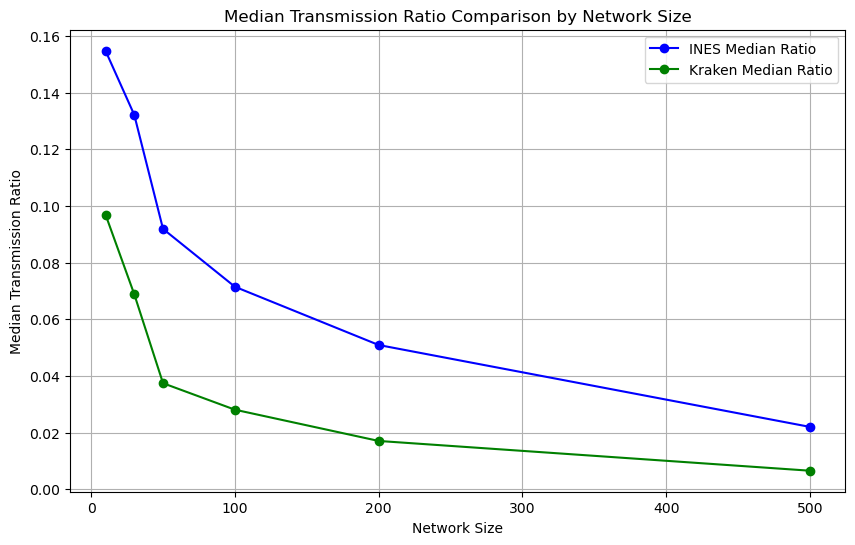

In [17]:
if all(
    col in df.columns
    for col in [
        "network_size",
        "inev_transmission_ratio",
        "ines_transmission_ratio",
        "kraken_transmission_ratio",
    ]
):
    summary = (
        df.groupby("network_size")
        .agg(
            inev_transmission_ratio_mean=("inev_transmission_ratio", "mean"),
            inev_transmission_ratio_median=("inev_transmission_ratio", "median"),
            ines_transmission_ratio_mean=("ines_transmission_ratio", "mean"),
            ines_transmission_ratio_median=("ines_transmission_ratio", "median"),
            kraken_transmission_ratio_mean=("kraken_transmission_ratio", "mean"),
            kraken_transmission_ratio_median=("kraken_transmission_ratio", "median"),
        )
        .reset_index()
    )

    # Plot median ratio comparison. Plot ratio on y-axis and network size on x-axis with different lines for each algorithm
    plt.figure(figsize=(10, 6))
    plt.plot(
        summary["network_size"],
        summary["ines_transmission_ratio_median"],
        marker="o",
        label="INES Median Ratio",
        color="blue",
    )
    plt.plot(
        summary["network_size"],
        summary["kraken_transmission_ratio_median"],
        marker="o",
        label="Kraken Median Ratio",
        color="green",
    )
    plt.xlabel("Network Size")
    plt.ylabel("Median Transmission Ratio")
    plt.title("Median Transmission Ratio Comparison by Network Size")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Columns for Transmission Ratio by Network Size plot not found.")

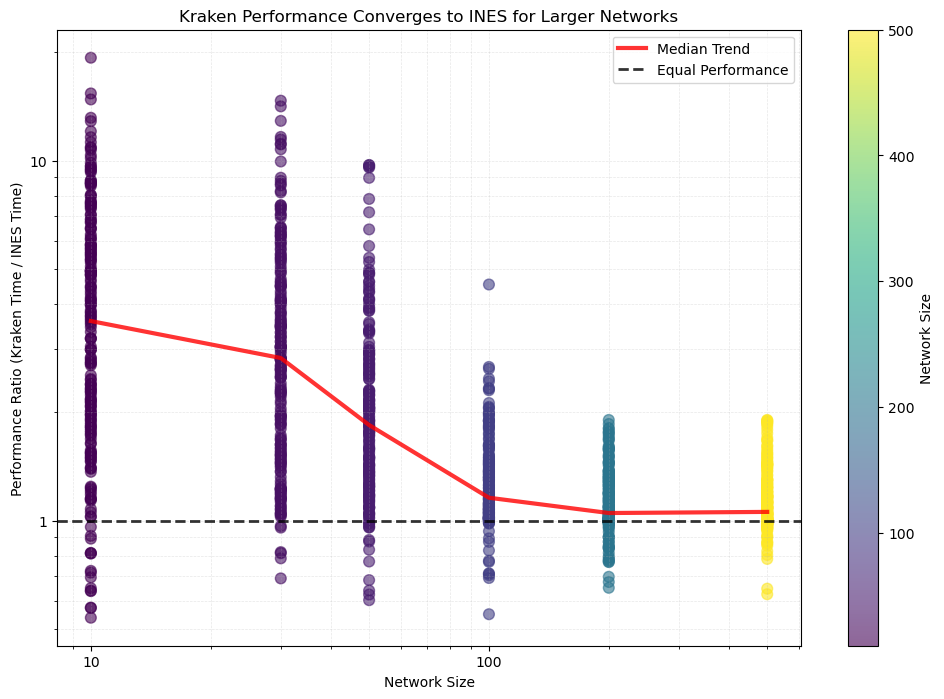

In [18]:
if all(
    col in df.columns
    for col in [
        "ines_total_time_seconds",
        "kraken_execution_time_seconds",
        "network_size",
    ]
):
    # Performance Ratio berechnen
    df["performance_ratio"] = (
        df["kraken_execution_time_seconds"] / df["ines_total_time_seconds"]
    )

    plt.figure(figsize=(12, 8))

    # Scatterplot mit Größenvariation
    scatter = plt.scatter(
        df["network_size"],
        df["performance_ratio"],
        c=df["network_size"],
        s=60,
        alpha=0.6,
        cmap="viridis",
    )

    # Trendlinie berechnen und plotten
    network_sizes = sorted(df["network_size"].unique())
    median_ratios = [
        df[df["network_size"] == size]["performance_ratio"].median()
        for size in network_sizes
    ]

    plt.plot(
        network_sizes, median_ratios, "r-", linewidth=3, label="Median Trend", alpha=0.8
    )

    # Referenzlinie bei y=1 (gleiche Performance)
    plt.axhline(
        y=1,
        color="black",
        linestyle="--",
        linewidth=2,
        label="Equal Performance",
        alpha=0.8,
    )

    plt.xscale("log")
    plt.yscale("log")

    # Normale Zahlen
    ax = plt.gca()
    ax.xaxis.set_major_formatter(
        ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
    )
    ax.yaxis.set_major_formatter(
        ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
    )

    plt.xlabel("Network Size")
    plt.ylabel("Performance Ratio (Kraken Time / INES Time)")
    plt.title("Kraken Performance Converges to INES for Larger Networks")
    plt.colorbar(scatter, label="Network Size")
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.3)
    plt.show()

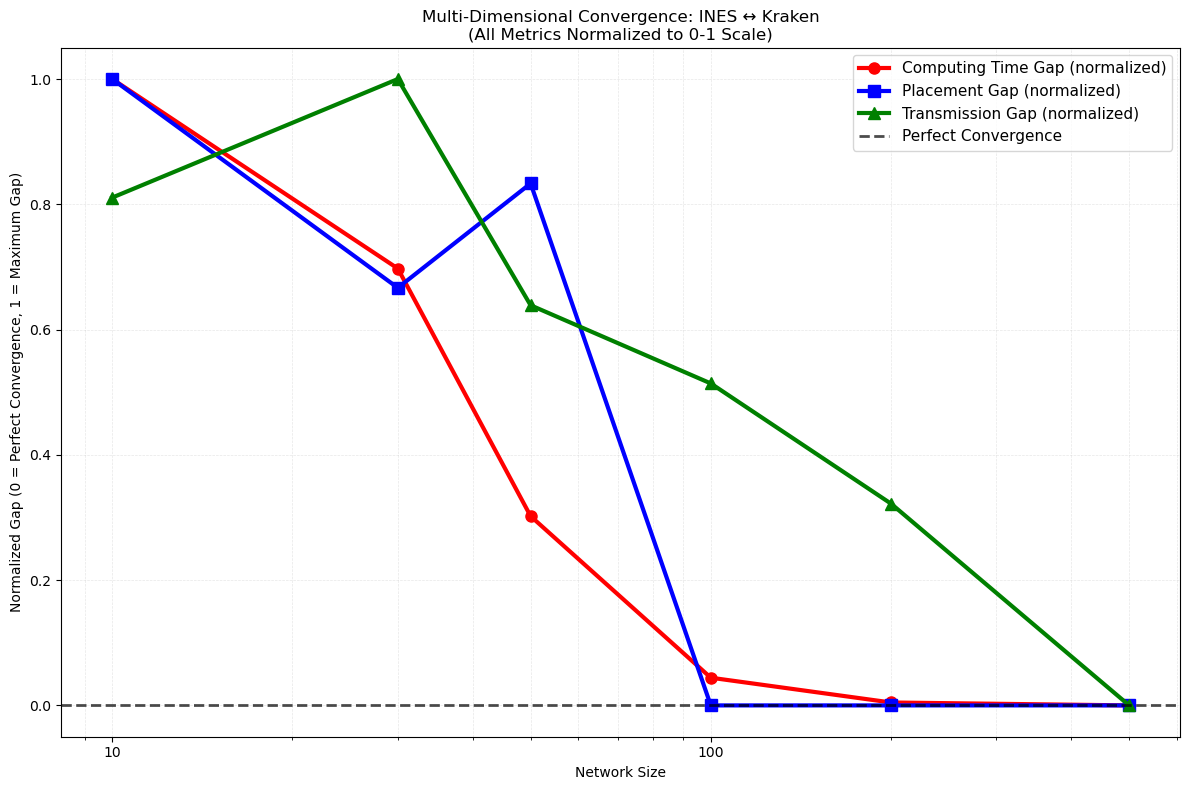

In [19]:
if all(
    col in df.columns
    for col in [
        "network_size",
        "performance_ratio",
        "placement_difference_to_ines_count",
        "ines_transmission_ratio",
        "kraken_transmission_ratio",
    ]
):
    # Convergence-Metriken berechnen
    df["transmission_ratio_difference"] = abs(
        df["ines_transmission_ratio"] - df["kraken_transmission_ratio"]
    )
    df["performance_convergence"] = abs(df["performance_ratio"] - 1.0)

    # Gruppieren
    summary = (
        df.groupby("network_size")
        .agg(
            performance_convergence_median=("performance_convergence", "median"),
            placement_diff_median=("placement_difference_to_ines_count", "median"),
            transmission_diff_median=("transmission_ratio_difference", "median"),
        )
        .reset_index()
    )

    # Normalisieren auf 0-1 Skala für besseren Vergleich
    scaler = MinMaxScaler()
    metrics_to_normalize = [
        "performance_convergence_median",
        "placement_diff_median",
        "transmission_diff_median",
    ]
    summary[["perf_norm", "place_norm", "trans_norm"]] = scaler.fit_transform(
        summary[metrics_to_normalize]
    )

    plt.figure(figsize=(12, 8))

    # Alle drei Metriken im gleichen Plot
    plt.plot(
        summary["network_size"],
        summary["perf_norm"],
        "o-",
        color="red",
        linewidth=3,
        markersize=8,
        label="Computing Time Gap (normalized)",
    )
    plt.plot(
        summary["network_size"],
        summary["place_norm"],
        "s-",
        color="blue",
        linewidth=3,
        markersize=8,
        label="Placement Gap (normalized)",
    )
    plt.plot(
        summary["network_size"],
        summary["trans_norm"],
        "^-",
        color="green",
        linewidth=3,
        markersize=8,
        label="Transmission Gap (normalized)",
    )

    # Konvergenz-Ziel
    plt.axhline(
        y=0,
        color="black",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label="Perfect Convergence",
    )

    plt.xscale("log")
    plt.xlabel("Network Size")
    plt.ylabel("Normalized Gap (0 = Perfect Convergence, 1 = Maximum Gap)")
    plt.title(
        "Multi-Dimensional Convergence: INES ↔ Kraken\n(All Metrics Normalized to 0-1 Scale)"
    )
    plt.legend(fontsize=11)
    plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.3)

    # X-Achse formatieren
    ax = plt.gca()
    ax.xaxis.set_major_formatter(
        ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
    )

    plt.tight_layout()
    plt.show()